In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb

from sklearn.metrics import roc_auc_score, log_loss
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold,KFold
from scipy.stats import norm, skew

from tqdm import tqdm_notebook as tqdm
from copy import copy
from multiprocessing import Pool

import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

In [2]:
# load data

In [3]:
use_experimental = False

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

indices_fake = np.load('synthetic_samples_indexes.npy')
indices_pub = np.load('public_LB.npy')
indices_pri = np.load('private_LB.npy')
indices_real = np.concatenate([indices_pub, indices_pri])

features = [c for c in train_df.columns if c not in ['ID_code', 'target']]
target_train = train_df['target']
X_train = train_df
X_test = test_df.loc[indices_real,:]
X_test['target'] = np.zeros(X_test.shape[0])
X_fake = test_df.loc[indices_fake,:]
X_fake['target'] = np.zeros(X_test.shape[0])
train_length = X_train.shape[0]
target_test = X_test['target']
target_fake = X_fake['target']

if use_experimental:
    np.random.seed(42)    
    indices = np.arange(train_length)
    train_length = 150000
    np.random.shuffle(indices)
    indices_train = indices[:train_length]
    indices_test = indices[train_length:]
    # Swapped order to not overwrite X_train to soon
    X_test = X_train.iloc[indices_test,:]
    X_fake = X_train.iloc[indices_test,:]
    target_fake = X_fake['target']
    X_train = X_train.iloc[indices_train,:]
    target_train = X_train['target']
    target_test = X_test['target']

X_all = pd.concat([X_train, X_test])
print(X_all.shape)


(300000, 202)


In [4]:
# Feature Engineering

In [5]:
import scipy.ndimage

sigma_fac = 0.001
sigma_base = 4

eps = 0.00000001

def get_count(X_all, X_fake):
    features_count = np.zeros((X_all.shape[0], len(features)))
    features_density = np.zeros((X_all.shape[0], len(features)))
    features_deviation = np.zeros((X_all.shape[0], len(features)))

    features_count_fake = np.zeros((X_fake.shape[0], len(features)))
    features_density_fake = np.zeros((X_fake.shape[0], len(features)))
    features_deviation_fake = np.zeros((X_fake.shape[0], len(features)))
    
    sigmas = []

    for i,var in enumerate(tqdm(features)):
        X_all_var_int = (X_all[var].values * 10000).round().astype(int)
        X_fake_var_int = (X_fake[var].values * 10000).round().astype(int)
        lo = X_all_var_int.min()
        X_all_var_int -= lo
        X_fake_var_int -= lo
        hi = X_all_var_int.max()+1
        counts_all = np.bincount(X_all_var_int, minlength=hi).astype(float)
        zeros = (counts_all == 0).astype(int)
        before_zeros = np.concatenate([zeros[1:],[0]])
        indices_all = np.arange(counts_all.shape[0])
        # Geometric mean of twice sigma_base and a sigma_scaled which is scaled to the length of array 
        sigma_scaled = counts_all.shape[0]*sigma_fac
        sigma = np.power(sigma_base * sigma_base * sigma_scaled, 1/3)
        sigmas.append(sigma)
        counts_all_smooth = scipy.ndimage.filters.gaussian_filter1d(counts_all, sigma)
        deviation = counts_all / (counts_all_smooth+eps)
        indices = X_all_var_int
        features_count[:,i] = counts_all[indices]
        features_density[:,i] = counts_all_smooth[indices]
        features_deviation[:,i] = deviation[indices]
        indices_fake = X_fake_var_int
        features_count_fake[:,i] = counts_all[indices_fake]
        features_density_fake[:,i] = counts_all_smooth[indices_fake]
        features_deviation_fake[:,i] = deviation[indices_fake]
        
    features_count_names = [var+'_count' for var in features]
    features_density_names = [var+'_density' for var in features]
    features_deviation_names = [var+'_deviation' for var in features]

    X_all_count = pd.DataFrame(columns=features_count_names, data = features_count)
    X_all_count.index = X_all.index
    X_all_density = pd.DataFrame(columns=features_density_names, data = features_density)
    X_all_density.index = X_all.index
    X_all_deviation = pd.DataFrame(columns=features_deviation_names, data = features_deviation)
    X_all_deviation.index = X_all.index
    X_all = pd.concat([X_all,X_all_count, X_all_density, X_all_deviation], axis=1)
    
    X_fake_count = pd.DataFrame(columns=features_count_names, data = features_count_fake)
    X_fake_count.index = X_fake.index
    X_fake_density = pd.DataFrame(columns=features_density_names, data = features_density_fake)
    X_fake_density.index = X_fake.index
    X_fake_deviation = pd.DataFrame(columns=features_deviation_names, data = features_deviation_fake)
    X_fake_deviation.index = X_fake.index
    X_fake = pd.concat([X_fake,X_fake_count, X_fake_density, X_fake_deviation], axis=1)    

    features_count = features_count_names
    features_density = features_density_names
    features_deviation = features_deviation_names
    return X_all, features_count, features_density, features_deviation, X_fake

X_all, features_count, features_density, features_deviation, X_fake = get_count(X_all, X_fake)
print(X_all.shape)


(300000, 802)


In [6]:
# standardize

In [7]:
features_to_scale = [features, features_count]

from sklearn.preprocessing import StandardScaler

def get_standardized(X_all, X_fake):
    scaler = StandardScaler()
    features_to_scale_flatten = [var for sublist in features_to_scale for var in sublist]
    scaler.fit(X_all[features_to_scale_flatten])
    features_scaled = scaler.transform(X_all[features_to_scale_flatten])
    features_scaled_fake = scaler.transform(X_fake[features_to_scale_flatten])
    X_all[features_to_scale_flatten] = features_scaled
    X_fake[features_to_scale_flatten] = features_scaled_fake
    return X_all, X_fake

X_all, X_fake = get_standardized(X_all, X_fake)

print(X_all.shape)

(300000, 802)


In [8]:
# Setting up Dataframes

In [9]:
X_train = X_all.iloc[:train_length,:]
X_test = X_all.iloc[train_length:,:]
del X_all
import gc
gc.collect()
print(X_train.shape, X_test.shape)

(200000, 802) (100000, 802)


In [10]:
# LGBM

In [11]:
features_used = [features, features_count]

In [12]:
# Params

In [13]:
params = {
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 1,
    'learning_rate': 0.08,
    'max_depth': -1,
    'metric':'binary_logloss',
    'num_leaves': 4,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary',
    'reg_alpha': 2,
    'reg_lambda': 0,
    'verbosity': 1,
    'max_bin':256,
}

# reg_alpha
reg_alpha_values = [0.75, 1, 2, 3]
reg_alpha_var = [3, 0, 2, 3, 2, 0, 1, 1, 3, 2, 2, 0, 2, 0, 2, 2, 2, 1, 1, 2, 1, 2, 3, 3, 2, 1, 3, 1, 3, 2, 2, 3, 1, 1, 3, 2, 0, 1, 0, 2, 1, 1, 2, 3, 0, 3, 3, 3, 2, 0, 3, 1, 3, 1, 1, 0, 2, 2, 0, 0, 0, 1, 2, 1, 0, 1, 3, 2, 0, 2, 1, 2, 0, 0, 1, 3, 3, 1, 2, 3, 3, 2, 0, 1, 2, 3, 3, 2, 3, 3, 0, 0, 3, 0, 1, 0, 1, 0, 2, 3, 1, 0, 3, 1, 3, 2, 3, 1, 3, 3, 3, 1, 3, 2, 3, 2, 1, 0, 1, 2, 0, 3, 0, 3, 0, 3, 2, 1, 0, 0, 2, 2, 2, 0, 1, 0, 0, 2, 3, 2, 2, 1, 1, 0, 1, 2, 2, 2, 1, 0, 2, 3, 2, 3, 1, 1, 3, 1, 1, 2, 1, 2, 0, 3, 1, 3, 3, 2, 0, 1, 3, 3, 0, 1, 0, 3, 1, 3, 1, 3, 0, 3, 0, 3, 1, 0, 0, 0, 3, 0, 3, 0, 0, 2, 0, 3, 1, 0, 3, 2]

# max_bin
max_bin_values = [256, 512, 1024]
max_bin_var = [0, 0, 1, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 1, 1, 1, 0, 0, 0, 0, 2, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 2, 1, 1, 1, 1, 0, 0, 0, 0, 1, 2, 1, 0, 0, 1, 2, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 2, 0, 1, 1, 0, 1, 0, 0, 1, 2, 1, 2, 1, 0, 0, 1, 0, 2, 0, 1, 0, 0, 2, 1, 1, 1, 0, 0, 0, 2, 0, 0, 2, 1, 0, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 2, 0, 1, 0, 1, 1, 0, 2, 1, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 1, 0, 1, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 1, 1, 0, 2, 0, 0, 0, 1, 2, 0, 0, 1, 0, 2]

# learning_rate
learning_rate_values = [0.06, 0.08, 0.12]
learning_rate_var = [2, 2, 2, 1, 2, 2, 2, 0, 1, 2, 0, 2, 2, 2, 0, 2, 2, 0, 2, 1, 2, 2, 2, 2, 2, 0, 1, 0, 2, 0, 0, 2, 0, 2, 2, 2, 1, 2, 0, 0, 2, 0, 0, 1, 2, 1, 2, 0, 0, 2, 1, 2, 2, 2, 2, 0, 0, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 1, 0, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 0, 2, 0, 2, 0, 2, 1, 0, 0, 1, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 1, 0, 2, 1, 2, 2, 1, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 1, 0, 2, 1, 1, 2, 2, 2, 2, 0, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 1, 2, 0, 2, 2, 0, 1, 2, 2, 2, 1, 0, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 0, 0, 2, 0, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1]

# num_leaves
num_leaves_values = [3, 4, 5]
num_leaves_var = [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 2, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 2, 1, 2, 0, 0, 0, 0, 0, 1, 1, 0, 0, 2, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1, 2, 1, 1, 1, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 2, 0, 1, 0, 2, 2, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 2, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 1, 2, 1, 1, 0, 0, 0, 2, 1, 2]


In [14]:
#training

In [15]:
n_folds = 5
early_stopping_rounds=10
settings = [4]
np.random.seed(47)

settings_best_ind = []

def train_trees():
    preds_oof = np.zeros((len(X_train), len(features)))
    preds_test = np.zeros((len(X_test), len(features)))
    preds_train = np.zeros((len(X_train), len(features)))
    preds_fake = np.zeros((len(X_fake), len(features)))

    features_used_flatten = [var for sublist in features_used for var in sublist]
    X_train_used = X_train[features_used_flatten]
    X_test_used = X_test[features_used_flatten]
    X_fake_used = X_fake[features_used_flatten]

    for i in range(len(features)):
        params['max_bin'] = max_bin_values[max_bin_var[i]]
        params['learning_rate'] = learning_rate_values[learning_rate_var[i]]
        params['reg_alpha'] = reg_alpha_values[reg_alpha_var[i]]
        params['num_leaves'] = num_leaves_values[num_leaves_var[i]]
        features_train = [feature_set[i] for feature_set in features_used] 
        print(f'Training on: {features_train}')
        folds = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=np.random.randint(100000))
        list_folds = list(folds.split(X_train_used.values, target_train.values))
        preds_oof_temp = np.zeros((preds_oof.shape[0], len(settings)))
        preds_test_temp = np.zeros((preds_test.shape[0], len(settings)))
        preds_train_temp = np.zeros((preds_train.shape[0], len(settings)))
        preds_fake_temp = np.zeros((preds_fake.shape[0], len(settings)))

        scores = []
        for j, setting in enumerate(settings):
            # setting is used for hyperparameter tuning, here you can add sometinh like params['num_leaves'] = setting
            print('\nsetting: ', setting)
            for k, (trn_idx, val_idx) in enumerate(list_folds):
                print("Fold: {}".format(k+1), end="")
                trn_data = lgb.Dataset(X_train_used.iloc[trn_idx][features_train], label=target_train.iloc[trn_idx])
                val_data = lgb.Dataset(X_train_used.iloc[val_idx][features_train], label=target_train.iloc[val_idx])

                # Binary Log Loss
                clf = lgb.train(params, trn_data, 2000, valid_sets=[trn_data, val_data], verbose_eval=False, early_stopping_rounds=early_stopping_rounds) 

                prediction_val1 = clf.predict(X_train_used.iloc[val_idx][features_train])
                prediction_test1 = clf.predict(X_test_used[features_train])
                prediction_train1 = clf.predict(X_train_used.iloc[trn_idx][features_train])
                prediction_fake1 = clf.predict(X_fake_used[features_train])

                # Predictions
                s1 = roc_auc_score(target_train.iloc[val_idx], prediction_val1)
                s1_log = log_loss(target_train.iloc[val_idx], prediction_val1)
                print(' - val AUC: {:<8.4f} - loss: {:<8.3f}'.format(s1, s1_log*1000), end='')

                # Predictions Test
                if use_experimental:
                    s1_test = roc_auc_score(target_test, prediction_test1)
                    s1_log_test = log_loss(target_test, prediction_test1)
                    print(' - test AUC: {:<8.4f} - loss: {:<8.3f}'.format(s1_test, s1_log_test*1000), end='')

                # Predictions Train
                s1_train = roc_auc_score(target_train.iloc[trn_idx], prediction_train1)
                s1_log_train = log_loss(target_train.iloc[trn_idx], prediction_train1)
                print(' - train AUC: {:<8.4f} - loss: {:<8.3f}'.format(s1_train, s1_log_train*1000), end='')
                if use_experimental:
                    print('',clf.feature_importance(), end='')

                print('')


                preds_oof_temp[val_idx,j] += np.sqrt(prediction_val1 - prediction_val1.mean() + 0.1) 
                preds_test_temp[:,j] += np.sqrt(prediction_test1 - prediction_test1.mean() + 0.1) / n_folds
                preds_train_temp[trn_idx,j] += np.sqrt(prediction_train1 - prediction_train1.mean() + 0.1) / (n_folds-1)
                preds_fake_temp[:,j] += np.sqrt(prediction_fake1 - prediction_fake1.mean() + 0.1) / n_folds

            score_setting = roc_auc_score(target_train, preds_oof_temp[:,j])
            score_setting_log = 1000*log_loss(target_train, np.exp(preds_oof_temp[:,j]))
            scores.append(score_setting_log)
            print("Score:  - val AUC: {:<8.4f} - loss: {:<8.3f}".format(score_setting, score_setting_log), end='')
            if use_experimental:
                score_setting_test = roc_auc_score(target_test, preds_test_temp[:,j])
                score_setting_log_test = 1000*log_loss(target_test, np.exp(preds_test_temp[:,j]))  
                print(" - test AUC: {:<8.4f} - loss: {:<8.3f}".format(score_setting_test, score_setting_log_test), end='')

            score_setting_train = roc_auc_score(target_train, preds_train_temp[:,j])
            score_setting_log_train = 1000*log_loss(target_train, np.exp(preds_train_temp[:,j]))
            print(" - train AUC: {:<8.4f} - loss: {:<8.3f}".format(score_setting_train, score_setting_log_train))

        best_ind = np.argmin(scores)
        settings_best_ind.append(best_ind)
        preds_oof[:,i] = preds_oof_temp[:,best_ind]
        preds_test[:,i] = preds_test_temp[:,best_ind]
        preds_train[:,i] = preds_train_temp[:,best_ind]
        preds_fake[:,i] = preds_fake_temp[:,best_ind]


        print('\nbest setting: ', settings[best_ind])
        preds_oof_cum = preds_oof[:,:i+1].mean(axis=1)
        print("Cum CV val  : {:<8.4f} - loss: {:<8.3f}".format(roc_auc_score(target_train, preds_oof_cum), 1000*log_loss(target_train, np.exp(preds_oof_cum))))
        if use_experimental:        
            preds_test_cum = preds_test[:,:i+1].mean(axis=1)
            print("Cum CV test : {:<8.4f} - loss: {:<8.3f}".format(roc_auc_score(target_test, preds_test_cum), 1000*log_loss(target_test, np.exp(preds_test_cum))))
        preds_train_cum = preds_train[:,:i+1].mean(axis=1)
        print("Cum CV train: {:<8.4f} - loss: {:<8.3f}".format(roc_auc_score(target_train, preds_train_cum), 1000*log_loss(target_train, np.exp(preds_train_cum))))
        print('*****' * 10 + '\n')
        
    return preds_oof, preds_test, preds_train, preds_fake

preds_oof, preds_test, preds_train, preds_fake = train_trees()

Training on: ['var_0', 'var_0_count']

setting:  4
Fold: 1[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 271
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5551   - loss: 323.450  - train AUC: 0.5540   - loss: 323.666 
Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 271
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - v

 - val AUC: 0.5560   - loss: 323.268  - train AUC: 0.5595   - loss: 323.228 
Score:  - val AUC: 0.5507   - loss: 31068.694 - train AUC: 0.5620   - loss: 31068.694

best setting:  4
Cum CV val  : 0.5965   - loss: 31068.694
Cum CV train: 0.6057   - loss: 31068.694
**************************************************

Training on: ['var_3', 'var_3_count']

setting:  4
Fold: 1[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 274
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

 - val AUC: 0.5103   - loss: 326.095  - train AUC: 0.5171   - loss: 325.884 
Score:  - val AUC: 0.5088   - loss: 31068.694 - train AUC: 0.5196   - loss: 31068.694

best setting:  4
Cum CV val  : 0.5978   - loss: 31068.694
Cum CV train: 0.6083   - loss: 31068.694
**************************************************

Training on: ['var_4', 'var_4_count']

setting:  4
Fold: 1[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 276
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

 - val AUC: 0.5259   - loss: 324.570  - train AUC: 0.5339   - loss: 324.429 
Fold: 3[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 267
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5282   - loss: 324.575  - train AUC: 0.5366   - loss: 324.333 
Fold: 4[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 267
[LightGBM] [Info] Number of data points in the train set: 160000, numbe

 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Fold: 3[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 269
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are 

Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 271
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
 - val AUC: 0.5158   - loss: 325.893  - train AUC: 0.5287   - loss: 325.597 
Fold: 3[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Fold: 3[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 268
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are 

 - val AUC: 0.5207   - loss: 325.657  - train AUC: 0.5280   - loss: 325.345 
Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1035
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5206   - loss: 325.736  - train AUC: 0.5295   - loss: 325.368 
Fold: 3[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1035
[LightGBM] [Info] Number of data points in the train set: 160000, num

 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 529
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are 

 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Score:  - val AUC: 0.5000   - loss: 31068.694 - train AUC: 0.5000   - loss: 31068.694

best setting:  4
Cum CV val  : 0.6714   - loss: 31068.694
Cum CV train: 0.6842   - loss: 31068.694
**************************************************

Training on: ['var_15', 'var_15_count']

setting:  4
Fold: 1[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 559
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5176   - loss: 325.928  - train AUC: 0.5234   - loss: 325.783 
Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wis

 - val AUC: 0.5045   - loss: 326.211  - train AUC: 0.5198   - loss: 325.918 
Score:  - val AUC: 0.5077   - loss: 31068.694 - train AUC: 0.5236   - loss: 31068.694

best setting:  4
Cum CV val  : 0.6724   - loss: 31068.694
Cum CV train: 0.6868   - loss: 31068.694
**************************************************

Training on: ['var_17', 'var_17_count']

setting:  4
Fold: 1[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 267
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning

 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Fold: 5[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 267
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are 

 - val AUC: 0.5038   - loss: 326.171  - train AUC: 0.5203   - loss: 325.723 
Fold: 3[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

 - val AUC: 0.5681   - loss: 322.692  - train AUC: 0.5606   - loss: 323.189 
Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1035
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5507   - loss: 324.136  - train AUC: 0.5641   - loss: 322.832 
Fold: 3[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1035
[LightGBM] [Info] Number of data points in the train set: 160000, num


setting:  4
Fold: 1[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 269
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

 - val AUC: 0.5111   - loss: 326.091  - train AUC: 0.5198   - loss: 325.918 
Score:  - val AUC: 0.5082   - loss: 31068.694 - train AUC: 0.5231   - loss: 31068.694

best setting:  4
Cum CV val  : 0.7071   - loss: 31068.694
Cum CV train: 0.7248   - loss: 31068.694
**************************************************

Training on: ['var_26', 'var_26_count']

setting:  4
Fold: 1[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 524
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5573   - loss: 322.803  - train AUC: 0.5642   - loss: 321.999 
Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wis

 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Fold: 4[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 277
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are 

 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 271
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are 

 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Score:  - val AUC: 0.5000   - loss: 31068.694 - train AUC: 0.5000   - loss: 31068.694

best setting:  4
Cum CV val  : 0.7193   - loss: 31068.694
Cum CV train: 0.7368   - loss: 31068.694
**************************************************

Training on: ['var_30', 'var_30_count']

setting:  4
Fold: 1[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning

 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Fold: 5[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are 

 - val AUC: 0.5292   - loss: 325.226  - train AUC: 0.5339   - loss: 325.086 
Fold: 5[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 529
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5312   - loss: 325.344  - train AUC: 0.5328   - loss: 325.057 
Score:  - val AUC: 0.5265   - loss: 31068.694 - train AUC: 0.5361   - loss: 31068.694

best setting:  4
Cum CV val  : 0.7234   - loss: 31068.694
Cum CV train: 0.7417   - loss: 31068.694
**************************************************

Training on: ['var_33', 'var_33_count']

setting:  4
Fold: 1[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wis

 - val AUC: 0.5366   - loss: 325.184  - train AUC: 0.5412   - loss: 324.905 
Fold: 5[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 526
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5356   - loss: 325.240  - train AUC: 0.5421   - loss: 324.876 
Score:  - val AUC: 0.5347   - loss: 31068.694 - train AUC: 0.5430   - loss: 31068.694

best setting:  4
Cum CV val  : 0.7375   - loss: 31068.694
Cum CV train: 0.7560   - loss: 31068.694
**************************************************

Training on: ['var_36', 'var_36_count']

setting:  4
Fold: 1[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wis

 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 270
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are 

 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Score:  - val AUC: 0.5000   - loss: 31068.694 - train AUC: 0.5000   - loss: 31068.694

best setting:  4
Cum CV val  : 0.7407   - loss: 31068.694
Cum CV train: 0.7601   - loss: 31068.694
**************************************************

Training on: ['var_39', 'var_39_count']

setting:  4
Fold: 1[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 268
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning

 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Fold: 5[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 268
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are 

 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Fold: 3[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 268
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training b

 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 544
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are 

 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Score:  - val AUC: 0.5000   - loss: 31068.694 - train AUC: 0.5000   - loss: 31068.694

best setting:  4
Cum CV val  : 0.7468   - loss: 31068.694
Cum CV train: 0.7659   - loss: 31068.694
**************************************************

Training on: ['var_43', 'var_43_count']

setting:  4
Fold: 1[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 567
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5264   - loss: 325.524  - train AUC: 0.5330   - loss: 325.327 
Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wis

 - val AUC: 0.5213   - loss: 325.572  - train AUC: 0.5293   - loss: 325.454 
Fold: 3[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Fold: 3[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 272
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are 

 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are 

 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Score:  - val AUC: 0.5000   - loss: 31068.694 - train AUC: 0.5000   - loss: 31068.694

best setting:  4
Cum CV val  : 0.7564   - loss: 31068.694
Cum CV train: 0.7759   - loss: 31068.694
**************************************************

Training on: ['var_48', 'var_48_count']

setting:  4
Fold: 1[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5306   - loss: 325.339  - train AUC: 0.5366   - loss: 325.178 
Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wis

 - val AUC: 0.5209   - loss: 325.833  - train AUC: 0.5264   - loss: 325.793 
Fold: 3[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 546
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

 - val AUC: 0.5238   - loss: 325.348  - train AUC: 0.5330   - loss: 324.863 
Score:  - val AUC: 0.5230   - loss: 31068.694 - train AUC: 0.5389   - loss: 31068.694

best setting:  4
Cum CV val  : 0.7638   - loss: 31068.694
Cum CV train: 0.7848   - loss: 31068.694
**************************************************

Training on: ['var_52', 'var_52_count']

setting:  4
Fold: 1[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 526
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5227   - loss: 325.830  - train AUC: 0.5232   - loss: 325.800 
Fold: 3[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000930 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5199   - loss: 325.947  - train AUC: 0.52

 - val AUC: 0.5101   - loss: 326.015  - train AUC: 0.5219   - loss: 325.901 
Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
 - val AUC: 0.5100   - loss: 326.049  - train AUC: 0.5249   - loss: 325.806 
Fold: 3[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is n

 - val AUC: 0.5121   - loss: 326.064  - train AUC: 0.5207   - loss: 325.833 
Score:  - val AUC: 0.5053   - loss: 31068.694 - train AUC: 0.5244   - loss: 31068.694

best setting:  4
Cum CV val  : 0.7779   - loss: 31068.694
Cum CV train: 0.8005   - loss: 31068.694
**************************************************

Training on: ['var_60', 'var_60_count']

setting:  4
Fold: 1[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000755 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 524
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
 - val AUC: 0.5101   - loss: 326.025  - train AU

Fold: 5[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 264
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
 - val AUC: 0.4984   - loss: 326.181  - train AUC: 0.5176   - loss: 325.897 
Score:  - val AUC: 0.5007   - loss: 31068.694 - train AUC: 0.5214   - loss: 31068.694

best setting:  4
Cum CV val  : 0.7781   - loss: 31068.694
Cum CV train: 0.8014   - loss: 31068.694
***

 - val AUC: 0.5109   - loss: 326.164  - train AUC: 0.5265   - loss: 325.737 
Score:  - val AUC: 0.5109   - loss: 31068.694 - train AUC: 0.5301   - loss: 31068.694

best setting:  4
Cum CV val  : 0.7784   - loss: 31068.694
Cum CV train: 0.8023   - loss: 31068.694
**************************************************

Training on: ['var_63', 'var_63_count']

setting:  4
Fold: 1[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 526
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5181   - loss: 325.785  - train AUC: 0.5201   - loss: 325.698 
Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wis

 - val AUC: 0.5069   - loss: 326.164  - train AUC: 0.5176   - loss: 325.956 
Fold: 4[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 268
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
 - val AUC: 0.5083   - loss: 326.152  - train AUC: 0.5202   - loss: 325.917 
Fold: 5[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosin

Fold: 1[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 458
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5152   - loss: 325.944  - train AUC: 0.5206   - loss: 325.897 
Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 458
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5076   - loss: 326.086  - train AUC: 0.52

 - val AUC: 0.5110   - loss: 325.919  - train AUC: 0.5198   - loss: 325.815 
Fold: 5[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 269
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 270
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5058   - loss: 326.084  - train AUC: 0.5203   - loss: 325.856 
Fold: 3[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 270
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5147   - loss: 325.918  - train AUC: 0.51

 - val AUC: 0.5286   - loss: 325.675  - train AUC: 0.5315   - loss: 325.422 
Fold: 3[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5211   - loss: 325.746  - train AUC: 0.5313   - loss: 325.428 
Fold: 4[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 160000, numbe

Score:  - val AUC: 0.5604   - loss: 31068.694 - train AUC: 0.5662   - loss: 31068.694

best setting:  4
Cum CV val  : 0.7969   - loss: 31068.694
Cum CV train: 0.8234   - loss: 31068.694
**************************************************

Training on: ['var_77', 'var_77_count']

setting:  4
Fold: 1[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1038
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5099   - loss: 325.900  - train AUC: 0.5235   - loss: 325.780 
Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000585 seconds.
You can set

 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 278
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are 

 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Score:  - val AUC: 0.5004   - loss: 31068.694 - train AUC: 0.5028   - loss: 31068.694

best setting:  4
Cum CV val  : 0.8013   - loss: 31068.694
Cum CV train: 0.8276   - loss: 31068.694
**************************************************

Training on: ['var_80', 'var_80_count']

setting:  4
Fold: 1[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 267
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5546   - loss: 322.847  - train AUC: 0.5630   - loss: 322.491 
Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wis

 - val AUC: 0.5198   - loss: 325.544  - train AUC: 0.5309   - loss: 325.062 
Score:  - val AUC: 0.5197   - loss: 31068.694 - train AUC: 0.5316   - loss: 31068.694

best setting:  4
Cum CV val  : 0.8166   - loss: 31068.694
Cum CV train: 0.8413   - loss: 31068.694
**************************************************

Training on: ['var_83', 'var_83_count']

setting:  4
Fold: 1[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

Fold: 1[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 526
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5224   - loss: 325.633  - train AUC: 0.5276   - loss: 325.382 
Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 526
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5248   - loss: 325.591  - train AUC: 0.52

Fold: 1[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 525
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5377   - loss: 325.043  - train AUC: 0.5397   - loss: 324.890 
Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 525
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5365   - loss: 324.993  - train AUC: 0.54

 - val AUC: 0.5400   - loss: 324.945  - train AUC: 0.5391   - loss: 324.659 
Fold: 5[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 271
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5337   - loss: 324.965  - train AUC: 0.5391   - loss: 324.737 
Score:  - val AUC: 0.5329   - loss: 31068.694 - train AUC: 0.5410   - loss: 31068.694

best setting:  4
Cum CV val  : 0.8253   - loss: 31068.694
Cum CV train: 0.8505   - loss: 31068.694
**************************************************

Training on: ['var_90', 'var_90_count']

setting:  4
Fold: 1[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wis

 - val AUC: 0.5410   - loss: 324.192  - train AUC: 0.5500   - loss: 323.744 
Fold: 5[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 526
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5321   - loss: 324.423  - train AUC: 0.5514   - loss: 323.744 
Score:  - val AUC: 0.5410   - loss: 31068.694 - train AUC: 0.5512   - loss: 31068.694

best setting:  4
Cum CV val  : 0.8312   - loss: 31068.694
Cum CV train: 0.8562   - loss: 31068.694
**************************************************

Training on: ['var_93', 'var_93_count']

setting:  4
Fold: 1[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wis

 - val AUC: 0.5332   - loss: 325.323  - train AUC: 0.5425   - loss: 324.721 
Fold: 5[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5377   - loss: 324.942  - train AUC: 0.5395   - loss: 324.880 
Score:  - val AUC: 0.5345   - loss: 31068.694 - train AUC: 0.5414   - loss: 31068.694

best setting:  4
Cum CV val  : 0.8364   - loss: 31068.694
Cum CV train: 0.8613   - loss: 31068.694
**************************************************

Training on: ['var_96', 'var_96_count']

setting:  4
Fold: 1[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wis

Fold: 4[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 265
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No furth

 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 291
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are 

 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Score:  - val AUC: 0.5000   - loss: 31068.694 - train AUC: 0.5000   - loss: 31068.694

best setting:  4
Cum CV val  : 0.8371   - loss: 31068.694
Cum CV train: 0.8622   - loss: 31068.694
**************************************************

Training on: ['var_99', 'var_99_count']

setting:  4
Fold: 1[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1044
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5436   - loss: 324.351  - train AUC: 0.5586   - loss: 323.128 
Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wi

 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Fold: 4[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 265
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are 

 - val AUC: 0.5212   - loss: 325.579  - train AUC: 0.5264   - loss: 325.348 
Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Fold: 3[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 335
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are 

 - val AUC: 0.5304   - loss: 325.586  - train AUC: 0.5303   - loss: 325.621 
Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1043
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5199   - loss: 325.933  - train AUC: 0.5332   - loss: 325.491 
Fold: 3[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1043
[LightGBM] [Info] Number of data points in the train set: 160000, num

 - val AUC: 0.5313   - loss: 325.242  - train AUC: 0.5380   - loss: 325.069 
Fold: 4[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 531
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
 - val AUC: 0.5247   - loss: 325.505  - train AUC: 0.5395   - loss: 324.986 
Fold: 5[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is n

 - val AUC: 0.5466   - loss: 323.148  - train AUC: 0.5516   - loss: 322.688 
Fold: 3[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 269
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5488   - loss: 323.054  - train AUC: 0.5522   - loss: 322.739 
Fold: 4[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 269
[LightGBM] [Info] Number of data points in the train set: 160000, numbe

Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 277
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
 - val AUC: 0.5323   - loss: 325.507  - train AUC: 0.5319   - loss: 325.451 
Fold: 3[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27

 - val AUC: 0.5249   - loss: 325.630  - train AUC: 0.5302   - loss: 325.393 
Fold: 3[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1050
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5220   - loss: 325.587  - train AUC: 0.5307   - loss: 325.418 
Fold: 4[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1050
[LightGBM] [Info] Number of data points in the train set: 160000, num

 - val AUC: 0.5056   - loss: 326.103  - train AUC: 0.5242   - loss: 325.888 
Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 265
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

 - val AUC: 0.5352   - loss: 324.602  - train AUC: 0.5362   - loss: 324.742 
Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 270
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5262   - loss: 324.908  - train AUC: 0.5358   - loss: 324.689 
Fold: 3[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 270
[LightGBM] [Info] Number of data points in the train set: 160000, numbe

 - val AUC: 0.5344   - loss: 325.059  - train AUC: 0.5457   - loss: 324.345 
Score:  - val AUC: 0.5350   - loss: 31068.694 - train AUC: 0.5467   - loss: 31068.694

best setting:  4
Cum CV val  : 0.8645   - loss: 31068.694
Cum CV train: 0.8892   - loss: 31068.694
**************************************************

Training on: ['var_122', 'var_122_count']

setting:  4
Fold: 1[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 269
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5317   - loss: 324.809  - train AUC: 0.5452   - loss: 324.327 
Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-w

 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 271
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are 

 - val AUC: 0.5162   - loss: 325.726  - train AUC: 0.5301   - loss: 325.411 
Fold: 3[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 312
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
 - val AUC: 0.5250   - loss: 325.616  - train AUC: 0.5298   - loss: 325.407 
Fold: 4[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is n

 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Fold: 4[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 310
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are 

 - val AUC: 0.5313   - loss: 325.360  - train AUC: 0.5273   - loss: 325.423 
Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1038
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5215   - loss: 325.652  - train AUC: 0.5293   - loss: 325.345 
Fold: 3[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1038
[LightGBM] [Info] Number of data points in the train set: 160000, num

Score:  - val AUC: 0.5266   - loss: 31068.694 - train AUC: 0.5348   - loss: 31068.694

best setting:  4
Cum CV val  : 0.8719   - loss: 31068.694
Cum CV train: 0.8967   - loss: 31068.694
**************************************************

Training on: ['var_131', 'var_131_count']

setting:  4
Fold: 1[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5260   - loss: 325.818  - train AUC: 0.5356   - loss: 325.160 
Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can se

 - val AUC: 0.5418   - loss: 324.428  - train AUC: 0.5518   - loss: 323.797 
Score:  - val AUC: 0.5454   - loss: 31068.694 - train AUC: 0.5536   - loss: 31068.694

best setting:  4
Cum CV val  : 0.8752   - loss: 31068.694
Cum CV train: 0.8998   - loss: 31068.694
**************************************************

Training on: ['var_134', 'var_134_count']

setting:  4
Fold: 1[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 524
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5170   - loss: 325.540  - train AUC: 0.5230   - loss: 325.490 
Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-w

 - val AUC: 0.5030   - loss: 326.122  - train AUC: 0.5167   - loss: 326.015 
Fold: 3[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 264
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are 

 - val AUC: 0.5239   - loss: 325.477  - train AUC: 0.5296   - loss: 325.276 
Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5335   - loss: 325.096  - train AUC: 0.5313   - loss: 325.274 
Fold: 3[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 160000, numbe

Cum CV train: 0.9022   - loss: 31068.694
**************************************************

Training on: ['var_139', 'var_139_count']

setting:  4
Fold: 1[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 267
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5764   - loss: 321.221  - train AUC: 0.5791   - loss: 321.014 
Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 267


 - val AUC: 0.5344   - loss: 324.823  - train AUC: 0.5387   - loss: 324.705 
Fold: 3[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 522
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5280   - loss: 324.856  - train AUC: 0.5378   - loss: 324.747 
Fold: 4[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 522
[LightGBM] [Info] Number of data points in the train set: 160000, numbe

 - val AUC: 0.5057   - loss: 326.129  - train AUC: 0.5198   - loss: 325.844 
Score:  - val AUC: 0.5057   - loss: 31068.694 - train AUC: 0.5217   - loss: 31068.694

best setting:  4
Cum CV val  : 0.8832   - loss: 31068.694
Cum CV train: 0.9076   - loss: 31068.694
**************************************************

Training on: ['var_144', 'var_144_count']

setting:  4
Fold: 1[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 542
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5195   - loss: 325.775  - train AUC: 0.5287   - loss: 325.528 
Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-w

 - val AUC: 0.5515   - loss: 323.383  - train AUC: 0.5640   - loss: 322.507 
Score:  - val AUC: 0.5561   - loss: 31068.694 - train AUC: 0.5660   - loss: 31068.694

best setting:  4
Cum CV val  : 0.8870   - loss: 31068.694
Cum CV train: 0.9112   - loss: 31068.694
**************************************************

Training on: ['var_147', 'var_147_count']

setting:  4
Fold: 1[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 267
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
 - val AUC: 0.5411   - loss: 324.115  - train AUC: 0.5449   - loss: 323.802 
Fold: 2[LightGBM] [Info] Number of positive:

 - val AUC: 0.5495   - loss: 324.657  - train AUC: 0.5548   - loss: 324.229 
Fold: 5[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 267
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5482   - loss: 324.713  - train AUC: 0.5546   - loss: 324.252 
Score:  - val AUC: 0.5497   - loss: 31068.694 - train AUC: 0.5555   - loss: 31068.694

best setting:  4
Cum CV val  : 0.8915   - loss: 31068.694
Cum CV train: 0.9151   - loss: 31068.694
**************************************************

Training on: ['var_150', 'var_150_count']

setting:  4
Fold: 1[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-w

 - val AUC: 0.5125   - loss: 325.855  - train AUC: 0.5165   - loss: 325.896 
Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 271
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Fold: 3[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1041
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are

 - val AUC: 0.5483   - loss: 323.664  - train AUC: 0.5483   - loss: 323.903 
Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 524
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5396   - loss: 324.169  - train AUC: 0.5513   - loss: 323.718 
Fold: 3[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 524
[LightGBM] [Info] Number of data points in the train set: 160000, numbe

 - val AUC: 0.5211   - loss: 325.789  - train AUC: 0.5235   - loss: 325.667 
Fold: 5[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 539
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Fold: 4[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 265
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are 

 - val AUC: 0.5155   - loss: 326.059  - train AUC: 0.5198   - loss: 325.909 
Fold: 4[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 268
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 329
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are 

 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Score:  - val AUC: 0.5000   - loss: 31068.694 - train AUC: 0.5000   - loss: 31068.694

best setting:  4
Cum CV val  : 0.8963   - loss: 31068.694
Cum CV train: 0.9200   - loss: 31068.694
**************************************************

Training on: ['var_162', 'var_162_count']

setting:  4
Fold: 1[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 278
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5266   - loss: 325.239  - train AUC: 0.5378   - loss: 325.049 
Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-w

 - val AUC: 0.5376   - loss: 324.670  - train AUC: 0.5464   - loss: 323.428 
Fold: 4[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 269
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5351   - loss: 323.823  - train AUC: 0.5450   - loss: 323.709 
Fold: 5[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 269
[LightGBM] [Info] Number of data points in the train set: 160000, numbe

 - val AUC: 0.5303   - loss: 325.026  - train AUC: 0.5357   - loss: 324.982 
Fold: 3[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5274   - loss: 325.293  - train AUC: 0.5362   - loss: 324.947 
Fold: 4[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 160000, numbe

 - val AUC: 0.5441   - loss: 323.600  - train AUC: 0.5463   - loss: 323.694 
Fold: 3[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 271
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5395   - loss: 323.718  - train AUC: 0.5477   - loss: 323.653 
Fold: 4[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 271
[LightGBM] [Info] Number of data points in the train set: 160000, numbe

 - val AUC: 0.5151   - loss: 325.906  - train AUC: 0.5225   - loss: 325.692 
Score:  - val AUC: 0.5121   - loss: 31068.694 - train AUC: 0.5247   - loss: 31068.694

best setting:  4
Cum CV val  : 0.9066   - loss: 31068.694
Cum CV train: 0.9288   - loss: 31068.694
**************************************************

Training on: ['var_172', 'var_172_count']

setting:  4
Fold: 1[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 268
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5426   - loss: 324.440  - train AUC: 0.5436   - loss: 324.579 
Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-w

 - val AUC: 0.5570   - loss: 322.496  - train AUC: 0.5569   - loss: 322.270 
Score:  - val AUC: 0.5530   - loss: 31068.694 - train AUC: 0.5583   - loss: 31068.694

best setting:  4
Cum CV val  : 0.9104   - loss: 31068.694
Cum CV train: 0.9320   - loss: 31068.694
**************************************************

Training on: ['var_175', 'var_175_count']

setting:  4
Fold: 1[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 530
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

 - val AUC: 0.5048   - loss: 326.182  - train AUC: 0.5166   - loss: 325.946 
Fold: 4[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1035
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
 - val AUC: 0.5071   - loss: 326.106  - train AUC: 0.5172   - loss: 325.960 
Fold: 5[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000613 seconds.


 - val AUC: 0.5338   - loss: 324.154  - train AUC: 0.5550   - loss: 323.098 
Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 273
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5442   - loss: 323.479  - train AUC: 0.5533   - loss: 323.191 
Fold: 3[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 273
[LightGBM] [Info] Number of data points in the train set: 160000, numbe

 - val AUC: 0.5162   - loss: 325.934  - train AUC: 0.5277   - loss: 325.723 
Fold: 3[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1055
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 268
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are 

 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Score:  - val AUC: 0.5000   - loss: 31068.694 - train AUC: 0.5000   - loss: 31068.694

best setting:  4
Cum CV val  : 0.9142   - loss: 31068.694
Cum CV train: 0.9356   - loss: 31068.694
**************************************************

Training on: ['var_184', 'var_184_count']

setting:  4
Fold: 1[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1035
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5512   - loss: 324.149  - train AUC: 0.5546   - loss: 323.436 
Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-

 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Fold: 4[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 267
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are 

 - val AUC: 0.5071   - loss: 325.843  - train AUC: 0.5299   - loss: 325.349 
Fold: 2[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
 - val AUC: 0.5126   - loss: 325.740  - train AUC: 0.5299   - loss: 325.297 
Fold: 3[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000801 seconds.
Y

 - val AUC: 0.5065   - loss: 326.133  - train AUC: 0.5185   - loss: 325.920 
Fold: 5[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1051
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5115   - loss: 326.047  - train AUC: 0.5179   - loss: 325.913 
Score:  - val AUC: 0.5082   - loss: 31068.694 - train AUC: 0.5198   - loss: 31068.694

best setting:  4
Cum CV val  : 0.9171   - loss: 31068.694
Cum CV train: 0.9384   - loss: 31068.694
**************************************************

Training on: ['var_190', 'var_190_count']

setting:  4
Fold: 1[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-

 - val AUC: 0.5527   - loss: 324.658  - train AUC: 0.5502   - loss: 324.685 
Fold: 5[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 280
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5390   - loss: 325.259  - train AUC: 0.5495   - loss: 324.803 
Score:  - val AUC: 0.5429   - loss: 31068.694 - train AUC: 0.5511   - loss: 31068.694

best setting:  4
Cum CV val  : 0.9202   - loss: 31068.694
Cum CV train: 0.9411   - loss: 31068.694
**************************************************

Training on: ['var_193', 'var_193_count']

setting:  4
Fold: 1[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing row-w

Fold: 4[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1039
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5188   - loss: 325.714  - train AUC: 0.5270   - loss: 325.492 
Fold: 5[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1039
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5288   - loss: 325.556  - train AUC: 0.

 - val AUC: 0.5313   - loss: 325.106  - train AUC: 0.5375   - loss: 324.894 
Fold: 4[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 541
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
 - val AUC: 0.5346   - loss: 325.202  - train AUC: 0.5397   - loss: 324.818 
Fold: 5[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 541
[LightGBM] [Info] Number of data points in the train set: 160000, numbe

Fold: 4[LightGBM] [Info] Number of positive: 16078, number of negative: 143922
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1033
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

In [16]:
# Training Summary

In [17]:
preds_oof_cum = np.zeros(preds_oof.shape[0])
if use_experimental:
    preds_test_cum = np.zeros(preds_test.shape[0])
preds_train_cum = np.zeros(preds_train.shape[0])
for i in range(len(features)):
    preds_oof_cum += preds_oof[:,i]
    preds_train_cum += preds_train[:,i]
    print("var_{} Cum val: {:<8.5f}".format(i,roc_auc_score(target_train, preds_oof_cum)), end="")
    if use_experimental:
        preds_test_cum += preds_test[:,i]
        print(" - test : {:<8.5f}".format(roc_auc_score(target_test, preds_test_cum)), end="")
    print(" - train: {:<8.5f}".format(roc_auc_score(target_train, preds_train_cum)))

var_0 Cum val: 0.54774  - train: 0.55891 
var_1 Cum val: 0.57384  - train: 0.58248 
var_2 Cum val: 0.59655  - train: 0.60574 
var_3 Cum val: 0.59778  - train: 0.60831 
var_4 Cum val: 0.59839  - train: 0.61025 
var_5 Cum val: 0.60777  - train: 0.61998 
var_6 Cum val: 0.62808  - train: 0.63917 
var_7 Cum val: 0.62808  - train: 0.63918 
var_8 Cum val: 0.63016  - train: 0.64208 
var_9 Cum val: 0.64072  - train: 0.65309 
var_10 Cum val: 0.64072  - train: 0.65309 
var_11 Cum val: 0.64324  - train: 0.65702 
var_12 Cum val: 0.66014  - train: 0.67316 
var_13 Cum val: 0.67142  - train: 0.68420 
var_14 Cum val: 0.67142  - train: 0.68420 
var_15 Cum val: 0.67225  - train: 0.68591 
var_16 Cum val: 0.67237  - train: 0.68684 
var_17 Cum val: 0.67237  - train: 0.68684 
var_18 Cum val: 0.68012  - train: 0.69512 
var_19 Cum val: 0.68115  - train: 0.69669 
var_20 Cum val: 0.68304  - train: 0.69908 
var_21 Cum val: 0.69371  - train: 0.70960 
var_22 Cum val: 0.70338  - train: 0.71908 
var_23 Cum val: 0.704

var_189 Cum val: 0.91712  - train: 0.93841 
var_190 Cum val: 0.91860  - train: 0.93960 
var_191 Cum val: 0.91960  - train: 0.94049 
var_192 Cum val: 0.92025  - train: 0.94110 
var_193 Cum val: 0.92043  - train: 0.94136 
var_194 Cum val: 0.92061  - train: 0.94158 
var_195 Cum val: 0.92099  - train: 0.94193 
var_196 Cum val: 0.92127  - train: 0.94220 
var_197 Cum val: 0.92177  - train: 0.94273 
var_198 Cum val: 0.92322  - train: 0.94385 
var_199 Cum val: 0.92353  - train: 0.94426 


In [18]:
print(settings)
print(settings_best_ind)

[4]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [19]:
# EDA on predictors

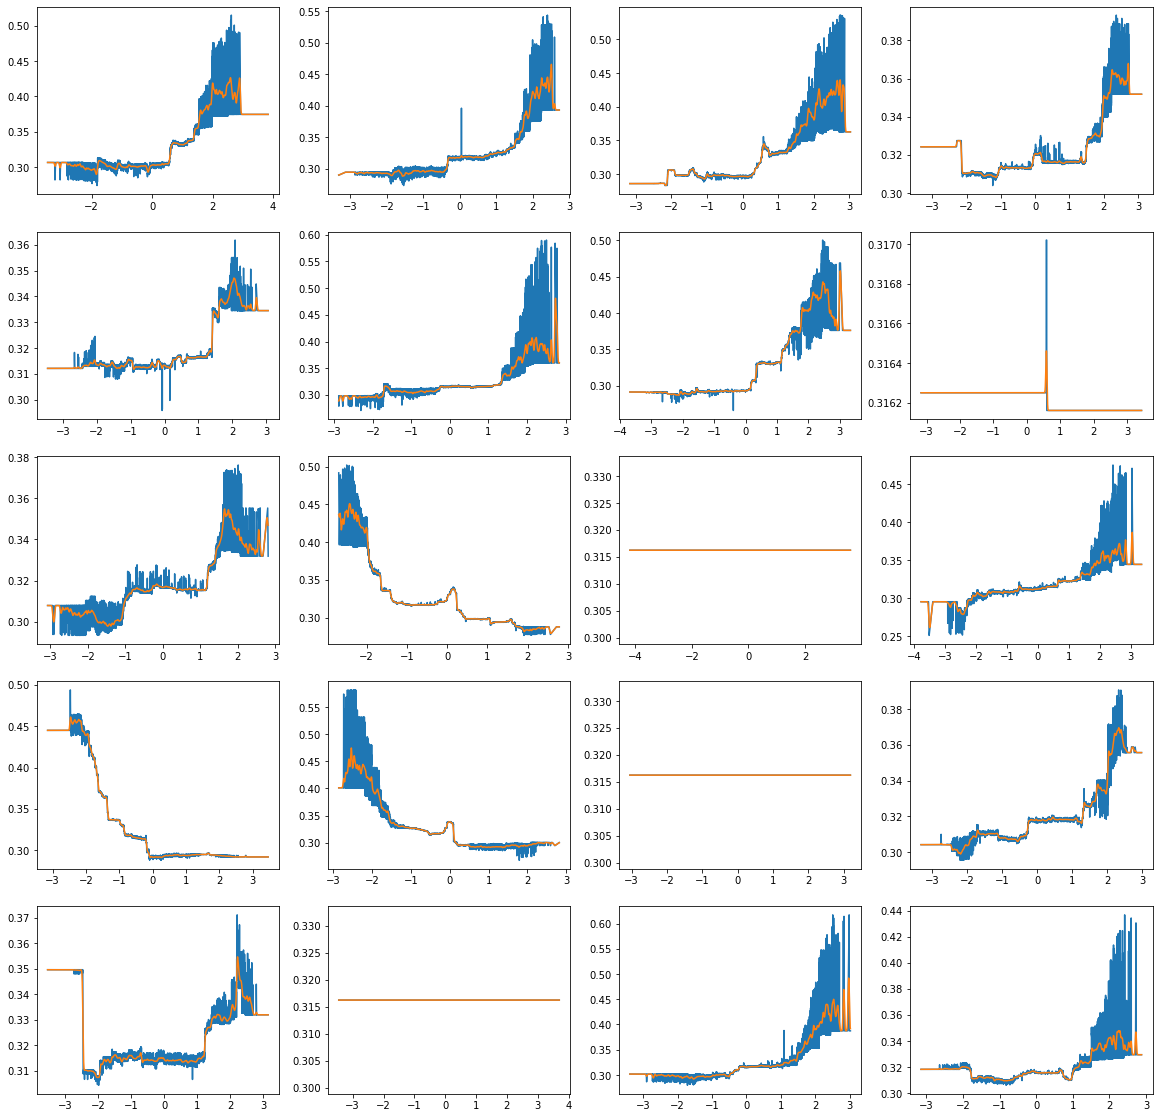

In [20]:
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt 

features_to_show = np.arange(20)
plt.figure(figsize = (20,20))

for i in features_to_show:
    var = 'var_'+str(i)
    signal = X_test[var].values
    logits = preds_test[:,i]
    func = interp1d(signal, logits)
    space = np.linspace(signal.min(), signal.max(), 4000)
    activations = func(space)
    activations_smooth = gaussian_filter(activations, 10)
    
    func_smooth = interp1d(space, activations_smooth)
    logits_smooth = func_smooth(signal)
    plt.subplot(5,4,i+1)
    plt.plot(space, activations)
    plt.plot(space, activations_smooth)

In [21]:
#CNN
#training

In [22]:
import keras

n_splits = 7
num_preds = 5
epochs = 60
learning_rate_init = 0.02
batch_size = 4000

num_features = len(features)

def get_features(preds, df):
    list_features = [preds, df[features].values, df[features_count].values, df[features_deviation], df[features_density]]
    list_indices = []
    for i in range(num_features):
        indices = np.arange(num_preds)*num_features + i
        list_indices.append(indices)
    indices = np.concatenate(list_indices)
    feats = np.concatenate(list_features, axis=1)[:,indices]
    return feats 

def get_model_3():
    inp = keras.layers.Input((num_features*num_preds,))
    x = keras.layers.Reshape((num_features*num_preds,1))(inp)
    x = keras.layers.Conv1D(32,num_preds,strides=num_preds, activation='elu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv1D(24,1, activation='elu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv1D(16,1, activation='elu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv1D(4,1, activation='elu')(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Reshape((num_features*4,1))(x)
    x = keras.layers.AveragePooling1D(2)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.BatchNormalization()(x)
    out = keras.layers.Dense(1, activation='sigmoid')(x)
    return keras.Model(inputs=inp, outputs=out)


def lr_scheduler(epoch):
    if epoch <= epochs*0.8:
        return learning_rate_init
    else:
        return learning_rate_init * 0.1

def train_NN(features_oof, features_test, features_train, features_fake):
    
    folds = StratifiedKFold(n_splits=n_splits)

    preds_nn_oof = np.zeros(features_oof.shape[0])
    preds_nn_test = np.zeros(features_test.shape[0])
    preds_nn_fake = np.zeros(features_fake.shape[0])

    for trn_idx, val_idx in folds.split(features_oof, target_train):
        features_oof_tr = features_oof[trn_idx, :]
        target_oof_tr = target_train.values[trn_idx]
        features_oof_val = features_oof[val_idx, :]
        target_oof_val = target_train.values[val_idx]

        optimizer = keras.optimizers.Adam(lr = learning_rate_init, decay = 0.00001)
        model = get_model_3()
        callbacks = []
        callbacks.append(keras.callbacks.LearningRateScheduler(lr_scheduler))
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        model.fit(features_oof_tr, target_oof_tr, validation_data=(features_oof_val, target_oof_val), epochs=epochs, verbose=2, batch_size=batch_size, callbacks=callbacks)

        preds_nn_oof += model.predict(features_oof, batch_size=2000)[:,0]
        preds_nn_test += model.predict(features_test, batch_size=2000)[:,0]
        preds_nn_fake += model.predict(features_fake, batch_size=2000)[:,0]

        print(roc_auc_score(target_train, preds_nn_oof))
        if use_experimental:
            print(roc_auc_score(target_test, preds_nn_test))
            print(roc_auc_score(target_test, preds_test.mean(axis=1)))

    preds_nn_oof /= n_splits
    preds_nn_test /= n_splits
    preds_nn_fake /= n_splits
    return preds_nn_oof, preds_nn_test, preds_nn_fake


features_oof = get_features(preds_oof, X_train)
features_test = get_features(preds_test, X_test)
if not use_experimental:
    del X_test
features_train = get_features(preds_train, X_train)
if not use_experimental:
    del X_train
features_fake = get_features(preds_fake, X_fake)
if not use_experimental:
    del X_fake
    del preds_oof
    del preds_fake
    del preds_train
    del preds_test

print(get_model_3().summary())
    
preds_nn_oof, preds_nn_test, preds_nn_fake = train_NN(features_oof, features_test, features_train, features_fake)

print(roc_auc_score(target_train, preds_nn_oof))
if use_experimental:
    print('test AUC: ', roc_auc_score(target_test, preds_nn_test))

ImportError: Keras requires TensorFlow 2.2 or higher. Install TensorFlow via `pip install tensorflow`

In [ ]:
#Generating submission

In [ ]:
preds_oof_final = preds_nn_oof
preds_test_final = preds_nn_test
preds_fake_final = preds_nn_fake

print('oof  : ', roc_auc_score(target_train, preds_oof_final))
if use_experimental:
    print('test : ', roc_auc_score(target_test, preds_test_final))
    print('train: ', roc_auc_score(target_fake, preds_fake_final))

if not use_experimental:
    sub = pd.DataFrame({"ID_code": test_df.ID_code.values})
    predictions_all = np.zeros(test_df.shape[0])
    predictions_all[indices_real] = preds_test_final
    predictions_all[indices_fake] = preds_fake_final
    sub["target"] = predictions_all
    sub.to_csv("submission.csv", index=False)
    print(sub.head(20))